In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
sys.path.append(os.path.abspath('..'))


from log_processing import process_log, from_csv

In [13]:
def calculate_vwaps(data):
    b1 = data["bid_price_1"]
    b1v = data["bid_volume_1"]
    b2 = data["bid_price_2"]
    b2v = data["bid_volume_2"]
    b3 = data["bid_price_3"]
    b3v = data["bid_volume_3"]
    a1 = data["ask_price_1"]
    a1v = data["ask_volume_1"]
    a2 = data["ask_price_2"]
    a2v = data["ask_volume_2"]
    a3 = data["ask_price_3"]
    a3v = data["ask_volume_3"]

    bid_vwap = (b1 * b1v + b2 * b2v + b3 * b3v) / (b1v + b2v + b3v)
    ask_vwap = (a1 * a1v + a2 * a2v + a3 * a3v) / (a1v + a2v + a3v)
    vwap = (bid_vwap + ask_vwap) / 2
    return bid_vwap, ask_vwap, vwap

In [14]:
round = 2

DAY_2 = 2
DAY_1 = 1
DAY_0 = 0
days = [DAY_2, DAY_1, DAY_0]

products = ["CROISSANTS", "JAMS", "DJEMBES", "PICNIC_BASKET1", "PICNIC_BASKET2"]
day_data = {}

for day in days:
    activities, trades = from_csv(round, day, "../../data")
    product_data = {}
    for product in products:
        product_data[product] = activities[activities["product"] == product].reset_index()

        product_data[product]["spread"] = product_data[product]["ask_price_1"] - product_data[product]["bid_price_1"]
        bid_vwap, ask_vwap, vwap = calculate_vwaps(product_data[product])
        product_data[product]["bid_vwap"] = bid_vwap
        product_data[product]["ask_vwap"] = ask_vwap
        product_data[product]["vwap"] = vwap

    day_data[day] = product_data


for day in days:
    synthetic_pb1_mid = 6 * day_data[day]["CROISSANTS"]["mid_price"] + 3 * day_data[day]["JAMS"]["mid_price"] + day_data[day]["DJEMBES"]["mid_price"]
    synthetic_pb1_ask = 6 * day_data[day]["CROISSANTS"]["ask_price_1"] + 3 * day_data[day]["JAMS"]["ask_price_1"] + day_data[day]["DJEMBES"]["ask_price_1"]
    synthetic_pb1_bid = 6 * day_data[day]["CROISSANTS"]["bid_price_1"] + 3 * day_data[day]["JAMS"]["bid_price_1"] + day_data[day]["DJEMBES"]["bid_price_1"]
    synthetic_pb1_vask = 6 * day_data[day]["CROISSANTS"]["ask_vwap"] + 3 * day_data[day]["JAMS"]["ask_vwap"] + day_data[day]["DJEMBES"]["ask_vwap"]
    synthetic_pb1_vbid = 6 * day_data[day]["CROISSANTS"]["bid_vwap"] + 3 * day_data[day]["JAMS"]["bid_vwap"] + day_data[day]["DJEMBES"]["bid_vwap"]
    synthetic_pb1_vwap = 6 * day_data[day]["CROISSANTS"]["vwap"] + 3 * day_data[day]["JAMS"]["vwap"] + day_data[day]["DJEMBES"]["vwap"]
    synthetic_pb1 = pd.DataFrame({
        "timestamp": day_data[day]["CROISSANTS"]["timestamp"],
        "mid_price": synthetic_pb1_mid,
        "ask_price_1": synthetic_pb1_ask,
        "bid_price_1": synthetic_pb1_bid,
        "ask_vwap": synthetic_pb1_vask,
        "bid_vwap": synthetic_pb1_vbid,
        "vwap": synthetic_pb1_vwap
    })
    synthetic_pb2_mid = 4 * day_data[day]["CROISSANTS"]["mid_price"] + 2 * day_data[day]["JAMS"]["mid_price"]
    synthetic_pb2_ask = 4 * day_data[day]["CROISSANTS"]["ask_price_1"] + 2 * day_data[day]["JAMS"]["ask_price_1"]
    synthetic_pb2_bid = 4 * day_data[day]["CROISSANTS"]["bid_price_1"] + 2 * day_data[day]["JAMS"]["bid_price_1"]
    synthetic_pb2_vask = 4 * day_data[day]["CROISSANTS"]["ask_vwap"] + 2 * day_data[day]["JAMS"]["ask_vwap"]
    synthetic_pb2_vbid = 4 * day_data[day]["CROISSANTS"]["bid_vwap"] + 2 * day_data[day]["JAMS"]["bid_vwap"]
    synthetic_pb2_vwap = 4 * day_data[day]["CROISSANTS"]["vwap"] + 2 * day_data[day]["JAMS"]["vwap"]
    synthetic_pb2 = pd.DataFrame({
        "timestamp": day_data[day]["CROISSANTS"]["timestamp"],
        "mid_price": synthetic_pb2_mid,
        "ask_price_1": synthetic_pb2_ask,
        "bid_price_1": synthetic_pb2_bid,
        "ask_vwap": synthetic_pb2_vask,
        "bid_vwap": synthetic_pb2_vbid,
        "vwap": synthetic_pb2_vwap
    })

    day_data[day]["SYN_PICNIC_BASKET1"] = synthetic_pb1
    day_data[day]["SYN_PICNIC_BASKET2"] = synthetic_pb2

In [15]:
combined_data = {}
for day in days:
    for product in day_data[day].keys():
        product_data = day_data[day][product]
        if product not in combined_data.keys():
            combined_data[product] = [product_data]
        else:
            product_data["timestamp"] += combined_data[product][-1]["timestamp"].max() + 100
            combined_data[product].append(product_data)

for product in combined_data.keys():
    combined_data[product] = pd.concat(combined_data[product], ignore_index=True).reset_index()

In [16]:
# Analyze each day separately or combine them
# data = day_data[DAY_1]
data = combined_data
time = data["CROISSANTS"]["timestamp"]

In [17]:
pb1_ask = data["PICNIC_BASKET1"]['ask_price_1']
pb1_bid = data["PICNIC_BASKET1"]['bid_price_1']
cro_ask = data["CROISSANTS"]['ask_price_1']
cro_bid = data["CROISSANTS"]['bid_price_1']
jams_ask = data["JAMS"]['ask_price_1']
jams_bid = data["JAMS"]['bid_price_1']
djem_ask = data["DJEMBES"]['ask_price_1']
djem_bid = data["DJEMBES"]['bid_price_1']

old_buy_spread = pb1_ask - (6 * cro_bid + 3 * jams_bid + djem_bid)
old_sell_spread = pb1_bid - (6 * cro_ask + 3 * jams_ask + djem_ask)

In [18]:
log_file = "../../backtests/test.log"
trader_data, products_data, activities, trades = process_log(log_file)

In [19]:
# Recorded data
sb1 = products_data["SYNTHETIC_BASKET1"]
sb1_buy_spread = sb1["buy_spread"]
sb1_sell_spread = sb1["sell_spread"]
sb1_zscore_buy = sb1["z_score_buy"]
sb1_zscore_sell = sb1["z_score_sell"]

# Actual data
pb1 = activities[activities["product"] == "PICNIC_BASKET1"].reset_index(drop=True)
cro = activities[activities["product"] == "CROISSANTS"].reset_index(drop=True)
jam = activities[activities["product"] == "JAMS"].reset_index(drop=True)
djem = activities[activities["product"] == "DJEMBES"].reset_index(drop=True)

new_time = pb1["timestamp"]

In [20]:
pb1_ask = pb1["ask_price_1"]
pb1_bid = pb1["bid_price_1"]

cro_ask = cro["ask_price_1"]
cro_bid = cro["bid_price_1"]

jam_ask = jam["ask_price_1"]
jam_bid = jam["bid_price_1"]

djem_ask = djem["ask_price_1"]
djem_bid = djem["bid_price_1"]

buy_spread = pb1_ask - (6 * cro_bid + 3 * jam_bid + djem_bid)
sell_spread = pb1_bid - (6 * cro_ask + 3 * jam_ask + djem_ask)

In [21]:
z_score_buy = (buy_spread - buy_spread.mean()) / buy_spread.std()
z_score_sell = (sell_spread - sell_spread.mean()) / sell_spread.std()

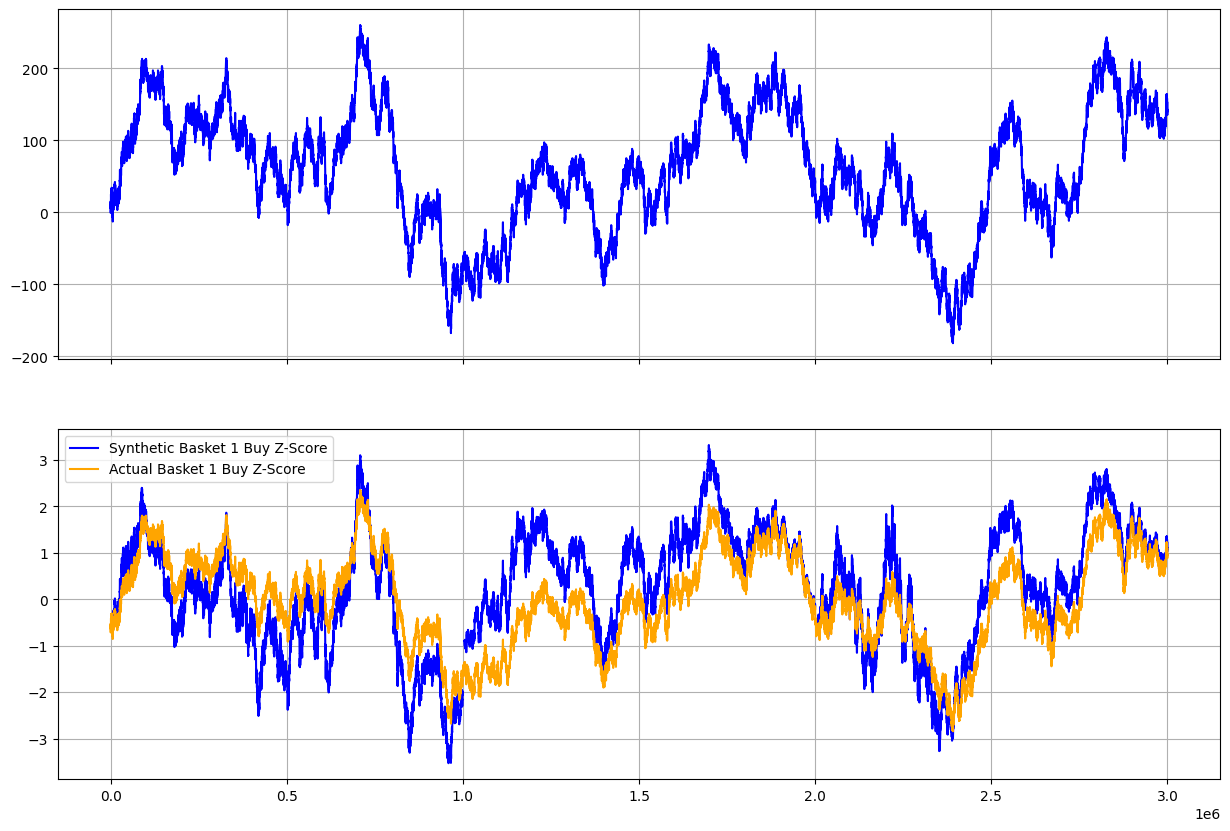

In [22]:
fig, axs = plt.subplots(2, 1, figsize=(15, 10), sharex=True)

axs[0].plot(new_time, sb1_buy_spread, label="Synthetic Basket 1 Buy Z-Score", color="blue")
axs[0].grid()

axs[1].plot(new_time, sb1_zscore_buy, label="Synthetic Basket 1 Buy Z-Score", color="blue")
axs[1].plot(new_time, z_score_buy, label="Actual Basket 1 Buy Z-Score", color="orange")
axs[1].grid()
axs[1].legend()

In [104]:
from collections import deque

class WelfordStatsWithPriors:
    def __init__(self, initial_mean=None, initial_variance=None, initial_count=10):
        self.n = initial_count if initial_mean is not None else 0
        self.mean = initial_mean if initial_mean is not None else 0.0
        self.M2 = initial_variance * initial_count if initial_variance is not None else 0.0
        
    def update(self, x):
        self.n += 1
        delta = x - self.mean
        self.mean += delta / self.n
        delta2 = x - self.mean
        self.M2 += delta * delta2
        
    def get_mean(self):
        return self.mean
    
    def get_std(self):
        return np.sqrt(self.M2 / self.n if self.n > 1 else 1.0)
    
N = 100
BUY_MEAN = 60.08
BUY_VAR = 7246.50
SELL_MEAN = 37.44
SELL_VAR = 7250.25

buy_stats = WelfordStatsWithPriors(initial_mean=BUY_MEAN, initial_variance=BUY_VAR, initial_count=N)
sell_stats = WelfordStatsWithPriors(initial_mean=SELL_MEAN, initial_variance=SELL_VAR, initial_count=N)

z_scores_buy_est = []
z_scores_sell_est = []

# Process the data
for i in range(len(buy_spread)):
    # Update statistics
    buy_stats.update(buy_spread[i])
    sell_stats.update(sell_spread[i])
    
    z_buy = (buy_spread[i] - buy_stats.get_mean()) / buy_stats.get_std()
    z_sell = (sell_spread[i] - sell_stats.get_mean()) / sell_stats.get_std()
    z_scores_buy_est.append(z_buy)
    z_scores_sell_est.append(z_sell)


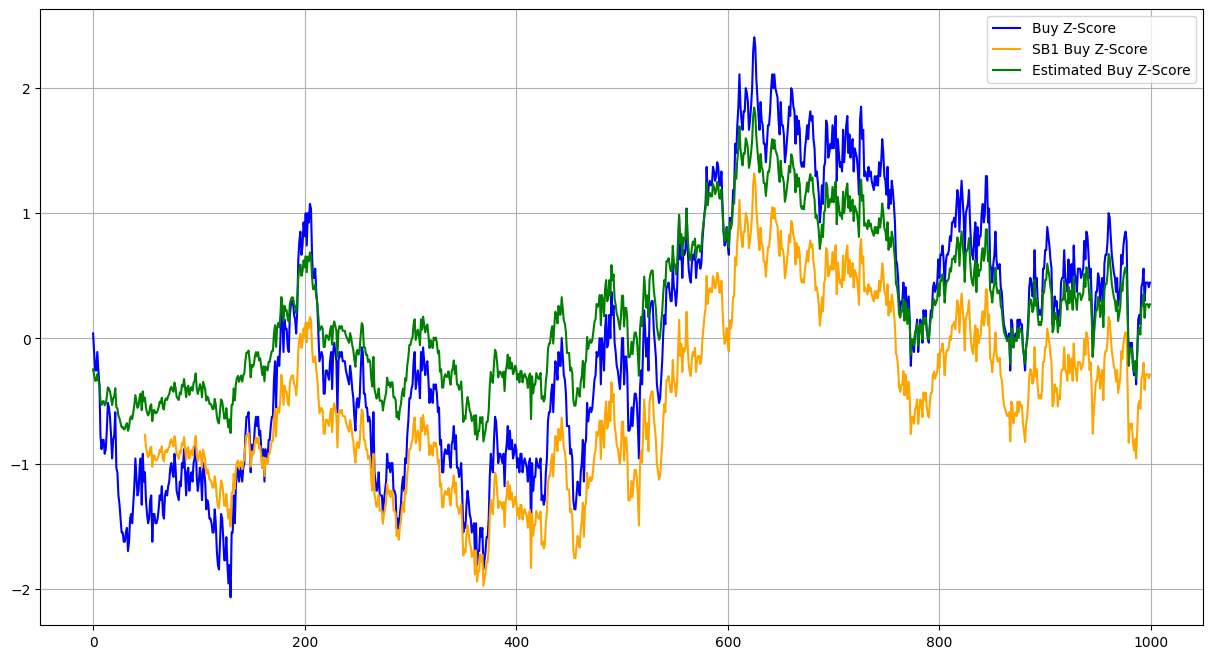

In [106]:
plt.figure(figsize=(15, 8))
plt.plot(z_score_buy, label="Buy Z-Score", color="blue")
plt.plot(sb1_zscore_buy, label="SB1 Buy Z-Score", color="orange")
plt.plot(z_scores_buy_est, label="Estimated Buy Z-Score", color="green")
plt.grid()
plt.legend()